

# CardioLife. Sprint 2  <img src="/Users/vioreliamagari/Desktop/capstone_may2024/images/logoCardioLife.png" alt="Image" width="150" style="float: right"/>
## Data preprocessing and base modelling

In the last sprint we did data cleaning and Exploratory Data Analysis. 
We discovered that, 
* The older patients have a higher risk of having a CVD
* Men has higher risk of having a CVD, compared to women
* Being overweight and obese, makes you more prone to having a cardiovascular disease
* Patients with a high blood pressure are more at risk to have a CVD
* Having high cholesterol and glucose in the blood, increases the risk of having a CVD
* Smoking and drinking alcohol doesn't influence too much the probability of having a CVD
* Having an active lifestyle decreases the risk of having a CVD

In this Sprint we will do:
## Table of Contents

1. [Data pre-processing](#Data_preprocessing)
2. [Baseline Modelling](#Baseline_Modelling)
3. [Model evaluation](#Model_evaluation)
4. [Best model, optimization](#Best_model)
5. [Future steps](#Future_steps)
6. [Conclusion](#Conclusion)

First of all, let's import the libraries, and read the csv file:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [7]:
cardio_df = pd.read_csv('/Users/vioreliamagari/Desktop/capstone_may2024/data/cardio_ds.csv')

#### **<a id='Data_preprocessing'> 1. Data pre-processing </a>**

During this step, we need to prepare the data for modelling. 
Let's look again at our dataset: 


In [27]:
cardio_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,18393,1,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,20228,0,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,18857,0,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,17623,1,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,17474,0,156,56.0,100,60,1,1,0,0,0,0,23.011177


We can drop the id column, as we won't need it for modelling: 

In [28]:
cardio_df = cardio_df.drop('id', axis=1)
cardio_df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,18393,1,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,20228,0,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,18857,0,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,17623,1,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,17474,0,156,56.0,100,60,1,1,0,0,0,0,23.011177


**One hot encoding the columns: `cholesterol`, `gluc`**

We need to encode the columns `cholesterol` and `gluc`, so we can have columns for each type of blood test result:
1. Normal - 1
2. Above normal - 2
3. Well above normal - 3

In [29]:
#import the library for OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the cholesterol and glucose column and transform
encoded = ohe.fit_transform(cardio_df[['cholesterol', 'gluc']])

# Put into a dataframe to get column names
encoded_df = pd.DataFrame(encoded.toarray(), columns=ohe.get_feature_names(['cholesterol', 'gluc']))
encoded_df.head()

,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0


Now we can delete the original columns: `cholesterol` and `gluc` and add the encoded columns instead to our cardio_df:

In [30]:
# delete the original cholesterol and gluc columns
cardio_df.drop(['cholesterol', 'gluc'], axis=1, inplace=True)

#add to cardio_df the encoded columns of cholesterol and gluc
cardio_df = pd.concat([cardio_df, encoded_df], axis=1)

Now, we can check the results: 

In [31]:
cardio_df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,bmi,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,18393,1,168,62.0,110,80,0,0,1,0,21.967120,1.0,0.0,0.0,1.0,0.0,0.0
1,20228,0,156,85.0,140,90,0,0,1,1,34.927679,0.0,0.0,1.0,1.0,0.0,0.0
2,18857,0,165,64.0,130,70,0,0,0,1,23.507805,0.0,0.0,1.0,1.0,0.0,0.0
3,17623,1,169,82.0,150,100,0,0,1,1,28.710479,1.0,0.0,0.0,1.0,0.0,0.0
4,17474,0,156,56.0,100,60,0,0,0,0,23.011177,1.0,0.0,0.0,1.0,0.0,0.0


Therefore, we can see that we encoded the columns correctly and our dataset is ready for modelling. The dataframe contains only numeric values and all the cathegorical columns are now encoded as binary columns.

#### **<a id='Baseline_Modelling'> 2. Baseline modelling </a>**

First of all, let's look at the percentage of people that has a CVD and people who don't have a CVD:

In [9]:
# Count the values from 'cardio' column
counts = cardio_df['cardio'].value_counts()

# Calculate percentage 
percentages = counts * 100 / cardio_df.shape[0]
print(percentages)

cardio
0    50.510137
1    49.489863
Name: count, dtype: float64


We see that 50,5% of the patients don't have a CVD and 49,5% have CVD. If we randomly guess if a person has CVD, we have 50% chance to make a right prediction. Therefore, our goal is to make a model that will predict with a much more high accuracy. 

In order to do so, we need to:
* Set up our data
* Split the training and test data
* Scalle our data
* Grid search for the best hyperparameters
* Build the models with the best hyperparameters


**Data setup** 

Before modelling we need to define what features are dependent variables and independent variable. Our independent variable is the column `cardio`, that is our target column, that will respond our question. Our dependent variables are all other features, that contains the information about a patient. 

In [32]:
#define X and Y
X = cardio_df.drop(['cardio'], axis=1)
y = cardio_df['cardio'] 

**Split train and test data**

Now, we will split our data into two parts:
1) *Train data* - the biggest part (80%), it will be the data that our models will be trained with
2) *Test data* - the smallest part (20%), it will be the data with the help of which we will test and evaluate our models

In [33]:
# import train test split
from sklearn.model_selection import train_test_split

#split the train (80%) and test data (20%), use stratify and random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    stratify=y,
                                                    random_state=42)

**Scalling the data**

After spliting our data, we can scale the data using Standard Scaler: 

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [35]:
#Initialize StandardScaler
scaler = StandardScaler()

#Fit and transform scaler on training data 
X_train_S = scaler.fit_transform(X_train)

#Transform test data using the scaler
X_test_S = scaler.transform(X_test)

Now we can proceeed to do modelling. 

##### 2.1. Logistic regression - baseline model

First of all, we can build a baseline model, to see what scores we obtain: 

In [36]:
# instantiate the logistic regression model 
log_reg = LogisticRegression()

#Fit training data 
log_reg.fit(X_train_S, y_train)

#Print the train and test score
print(f'Train Score: {log_reg.score(X_train_S, y_train)}')
print(f'Test Score: {log_reg.score(X_test_S, y_test)}')

Train Score: 0.7266608613620696
Test Score: 0.7263623829910747


We see that we have a relatively good score (Train score= 0.726, Test score= 0,726). But we can try to see if we get better results. 

In order to do that, we will use Grid Search, to search over the models parameters and find the best ones. 

In [85]:
#define the parameters that the GridSearch will search through
param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'solver': ['saga', 'liblinear'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }
]
# use GridSearchCv to search through LogisticRegression, cross-validation=5
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
fittedgrid = grid.fit(X_train, y_train)

/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-pac

The best hyperparameters for Logistic Regression are:

In [87]:
# Best hyperparameters
fittedgrid.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

The best score that the GridSearch could optain is: 

In [88]:
fittedgrid.best_score_

0.7257862592302338

Now we know what are the hyperparameters that logistic regression need, and we can build the logistic regression with these parameters: 

In [37]:
# instantiate the logistic regression model with the best hyperparameters
best_log_reg = LogisticRegression(C = 10, 
                                  penalty = 'l1', 
                                  solver = 'liblinear', 
                                  )

#Fit training data 
best_log_reg.fit(X_train_S, y_train)

#Print the train and test score
print(f'Train Score: {best_log_reg.score(X_train_S, y_train)}')
print(f'Test Score: {best_log_reg.score(X_test_S, y_test)}')

Train Score: 0.7268604187075941
Test Score: 0.7265075103403237


Therefore, we got the best score of the training data = 0,727 and of the test data 0,727. It means that there is no overfitting and the model's performance on the training data is similar to the performance on the test data.  

##### 2.2. Decision Tree Classifier

Now let's find the best hyperparameters for decision tree classifier and see if we will got better results.

*Note*: We tried to do GridSearch for all the training data, but it took a lot of time. Therefore, we will do the GridSearch for half of the training data, and then we will use the best hyperparameters to fit and transform our all training data. 

In [116]:
#define the parameters that the GridSearch will search through
param_grid = [
    {
        'max_depth': list(range(1,10)),
        'min_samples_leaf': list(range(1,20)),
        'min_samples_split': [2,4,6,8,10,14,20], 
        'criterion': ['gini', 'entropy']
    }
]
#use GridSearch 
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
fittedgrid = grid.fit(X_train[::2], y_train[::2])

Now, let's look at the best parameters of the Decision Tree Classifier: 

In [117]:
# Best hyperparameters
fittedgrid.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'min_samples_leaf': 9,
 'min_samples_split': 20}

The best score of the GridSearch is: 

In [118]:
fittedgrid.best_score_

0.7274242802960321

Now, we can build the Decision Tree Classifier, using the best parameters: 

In [38]:
# instantiate the Decision Tree Classifier model with the best hyperparameters
best_dec_tree = DecisionTreeClassifier(criterion = 'entropy', 
                                       max_depth = 5, 
                                       min_samples_leaf= 9,
                                       min_samples_split= 20 
                                  )

#Fit training data 
best_dec_tree.fit(X_train_S, y_train)

#Print the train and test score
print(f'Train Score: {best_dec_tree.score(X_train_S, y_train)}')
print(f'Test Score: {best_dec_tree.score(X_test_S, y_test)}')

Train Score: 0.7312325387322666
Test Score: 0.733763877802772


We can observe that we got better results (Train score= 0.731, Test score= 0.733) than Logistic Regression and there is also no overfitting.

We can look at the plot tree of the model:

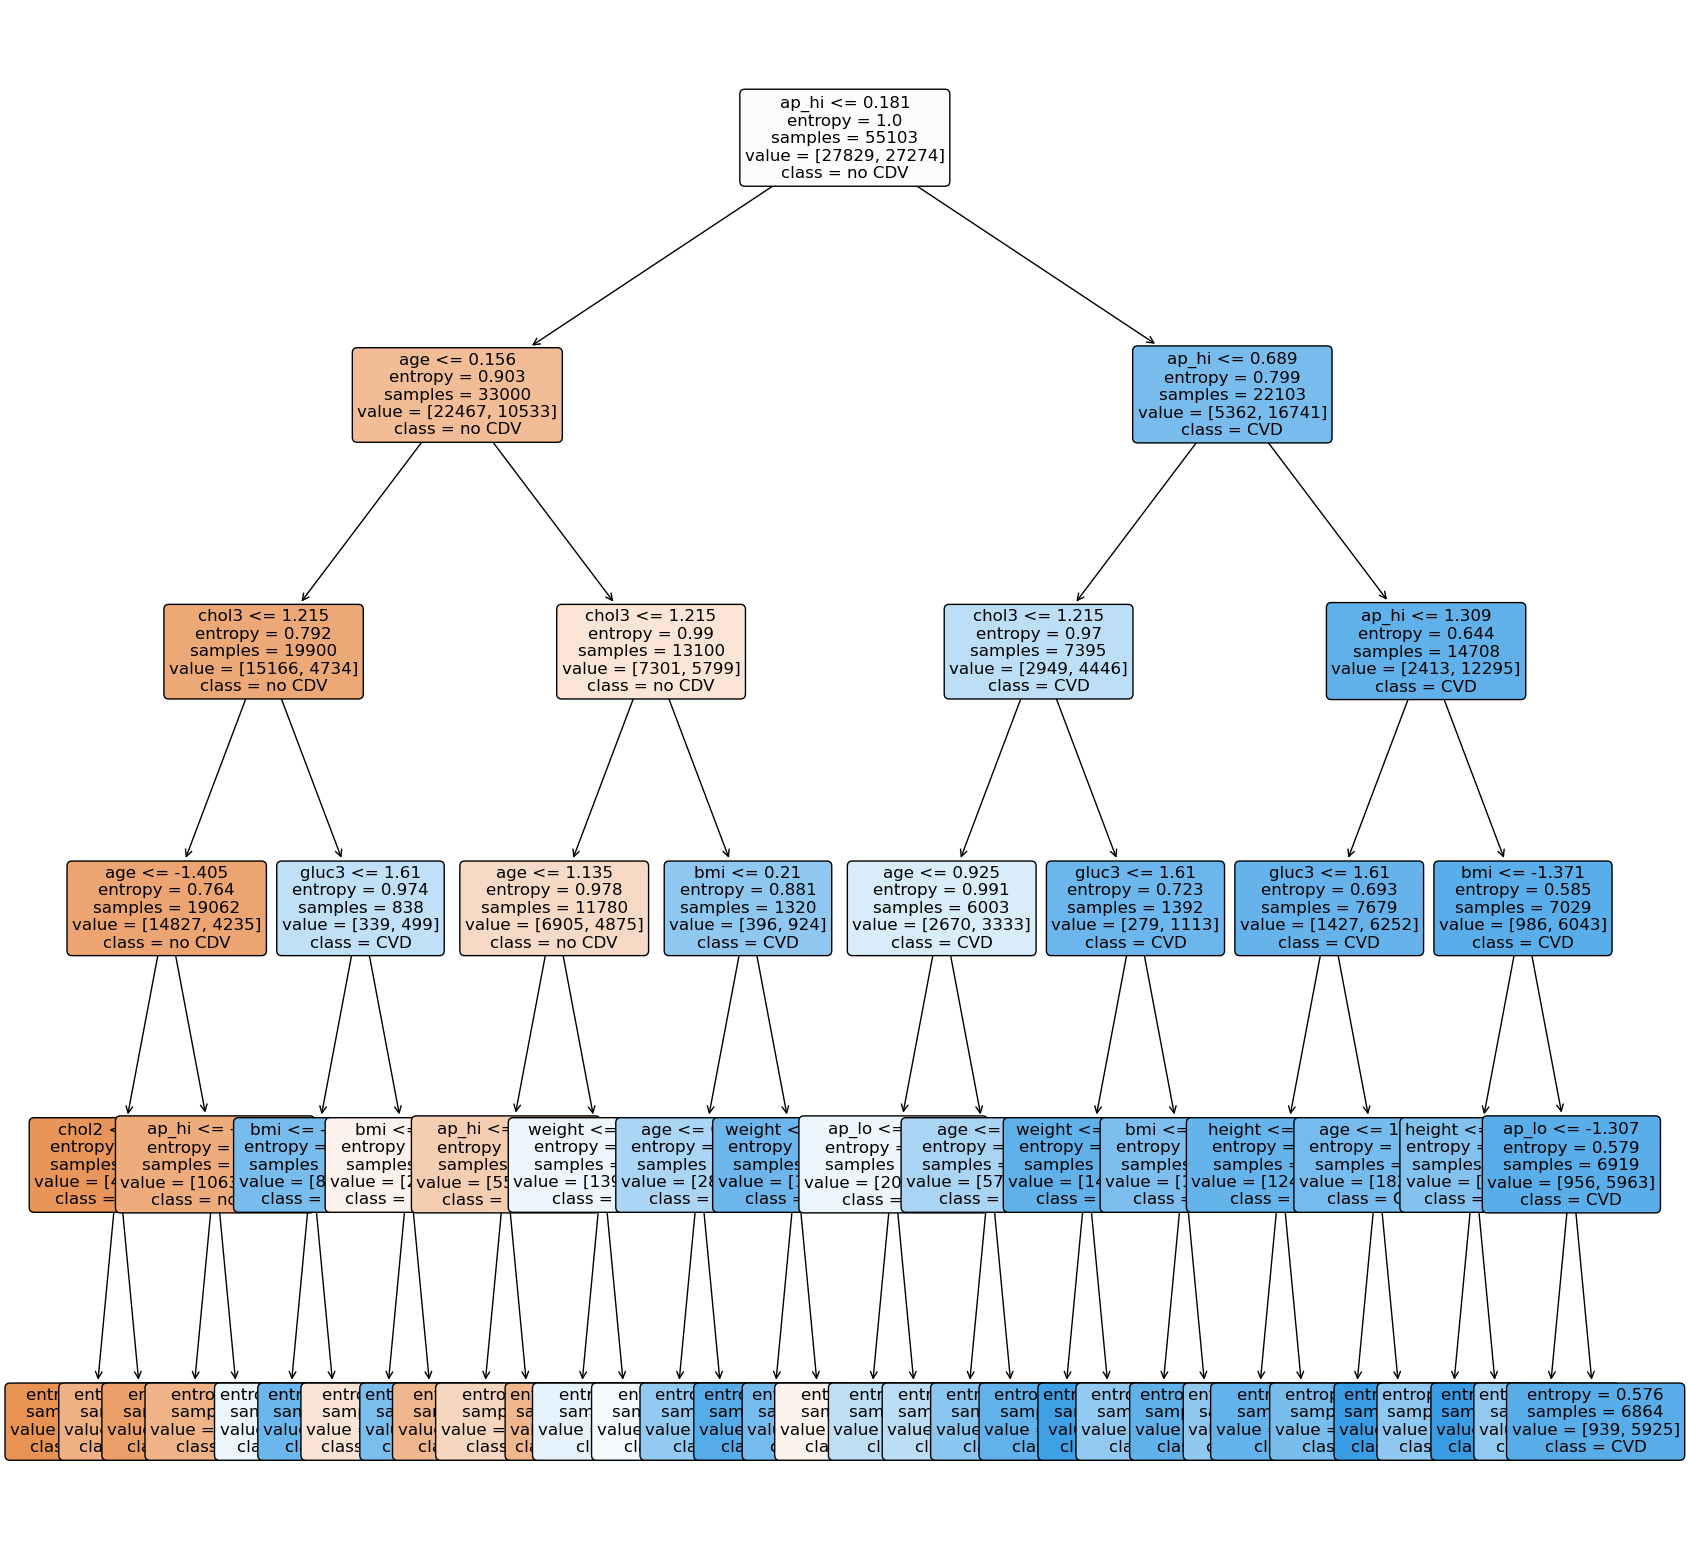

In [136]:
from sklearn.tree import plot_tree
#Transform scaled X_train into a DataFrame for visualisation
X_train_S_df = pd.DataFrame(X_train_S, columns= ['age', 'gender', 'height', 
                                                 'weight', 'ap_hi', 'ap_lo', 
                                                 'smoke', 'alco', 'active', 
                                                 'bmi', 'chol1', 'chol2', 
                                                 'chol3', 'gluc1', 
                                                 'gluc2', 'gluc3'])
#ploy the tree 
plt.figure(figsize=(20, 20))
plot_tree(best_dec_tree, 
          feature_names= X_train_S_df.columns, 
          class_names=["no CDV", "CVD"],
          rounded=True,
          filled=True, 
          fontsize=12)
plt.show()

##### 2.3. K- nearest neighbours

Now let's find the best hyperparameters for K-nearest neighbours classifier.

*Note*: We will do the GridSearch for half of the training data, and then we will use the best hyperparameters to fit and transform our all training data. 

In [159]:
# GridSearch parameters
param_grid = {
    'n_neighbors': [5, 10, 15, 20, 25],
    'p': [1, 2],
    'weights': ['uniform', 'distance']
}
# Instantiate the GridSearch and fit to train data
fittedgrid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
fittedgrid.fit(X_train_S[::2], y_train[::2])

/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None wi

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 10, 15, 20, 25], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

The best parameters are:

In [160]:
# Best hyperparameters
fittedgrid.best_params_

{'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}

The best score is: 

In [161]:
fittedgrid.best_score_

0.7206009034562454

We can build the KNeighborsClassifier model, using the best parameters: 

In [39]:
# instantiate the logistic regression model with the best hyperparameters
best_KNN = KNeighborsClassifier(n_neighbors = 25,  
                                p= 1,
                                weights= 'uniform'
                              )

#Fit training data 
best_KNN.fit(X_train_S, y_train)

#Print the train and test score
print(f'Train Score: {best_KNN.score(X_train_S, y_train)}')
print(f'Test Score: {best_KNN.score(X_test_S, y_test)}')

/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Train Score: 0.7429157142338813
Test Score: 0.7252013641970829


/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Therefore we got better train score: 0.743, and the test score 0,725. 

#### **<a id='Model_evaluation'> 3. Model evaluation </a>**

To understand better if our models have performed well, we should do model evaluation. This includes: 
- confusion matrix 
- classification report with precision, recall, accuracy and f1
- ROC curve and AUC score

##### 3.1. Logistic regression model evaluation

We can look at the confusion matrix of the best Logistic Regression model:

<Figure size 800x600 with 0 Axes>

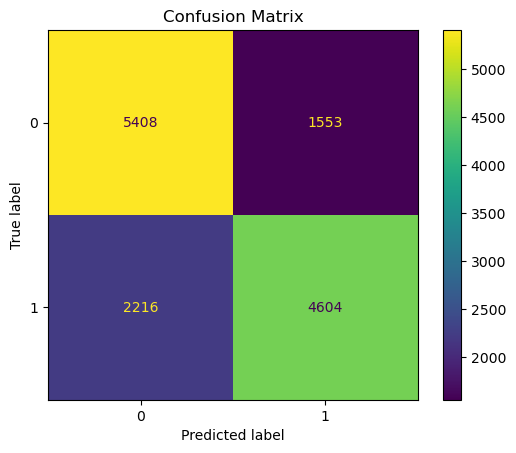

In [41]:
from sklearn.metrics import plot_confusion_matrix

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(best_log_reg, X_test_S, y_test, values_format='d')
plt.title('Confusion Matrix')
plt.show()

Therefore, we observe that there is:
We can tell that there is:
* 5408 patients that were correctly predicted to be without a CVD (true negative)
* 2216 patients that were incorrectly predicted to be without CVD (false negative), in reality they have this diagnose
* 1553 patients that were incorrectly predicted to be with a CVD (false positive), in reality they were healthy
* 4604 patients that were correctly predicted to be with a CVD(true positive)

Now let's look at the classification report: 

In [42]:
from sklearn.metrics import classification_report

#Get predictions
y_pred_log = best_log_reg.predict(X_test_S)

#make classification report
report_log = classification_report(y_test, y_pred_log)
print(report_log)

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      6961
           1       0.75      0.68      0.71      6820

    accuracy                           0.73     13781
   macro avg       0.73      0.73      0.73     13781
weighted avg       0.73      0.73      0.73     13781



We see that the ratio between the correctly predicted patients who have a CVD to the total of patients who have a CVD, or the *precision*, is 0.75. The ratio of correctly predicted patients who have a CVD to all patients, or the *recall*, is 0.68. The mean of precision and recall, or *F1-score*, is 0.71, and the *accuracy* is 0.73. 

We can tell that the logistic regression model is a good model, but we need to make sure that we have less false negatives, and that the recall is higher. 

Now, let's look at the ROC curse and AUC score of the Logistic regression model: 

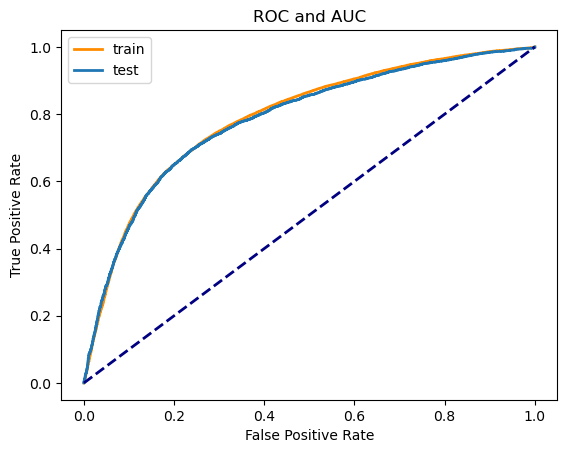

Test AUC score: 0.7850502969834869
Train AUC score: 0.7899282695651056


In [43]:
from sklearn.metrics import roc_curve, roc_auc_score

#Get the probability for each point in the test set.
y_proba_test_log = best_log_reg.predict_proba(X_test_S)[:,1]

#Get the probability for each point in the train set.
y_proba_train_log = best_log_reg.predict_proba(X_train_S)[:,1]

# Compute ROC curve and AUC for for the one class
roc_auc_test = roc_auc_score(y_test, y_proba_test_log)
fprs_test, tprs_test, thresholds_test = roc_curve(y_test, y_proba_test_log)

fprs_train, tprs_train, thresholds_train = roc_curve(y_train, y_proba_train_log)
roc_auc_train = roc_auc_score(y_train, y_proba_train_log)

# Plot the ROC curve.
plt.figure()
plt.plot(fprs_train, tprs_train, color='darkorange', lw=2, label='train')
plt.plot(fprs_test, tprs_test, lw=2, label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="best")
plt.show()
print(f"Test AUC score: {roc_auc_test}")
print(f"Train AUC score: {roc_auc_train}")

We can observe that the ROC curve for the test data is slightly above, or equal to the ROC curve of the training data. That might indicate that the Logistic regression model performs better on the test data. Also, both curves are close to the top-left corner, suggesting a high accuracy. 

The test AUC score is 0.785 and the train AUC score is 0.79. They are quite similar, indicating that the model generalizes well from training to test data without significant overfitting or underfitting. We can tell that the Logistic Regression model has a strong predictive performance. 

##### 3.2. Decision Tree model evaluation

Now, let's look at the Decision Tree Classifier model confusion matrix: 

<Figure size 800x600 with 0 Axes>

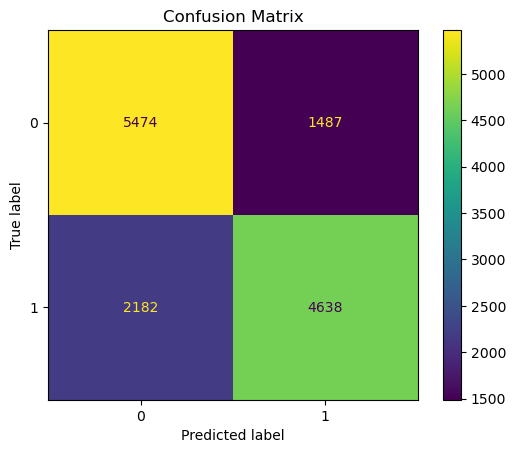

In [44]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(best_dec_tree, X_test_S, y_test, values_format='d')
plt.title('Confusion Matrix')
plt.show()

We can see that:
* 5474 patients that were correctly predicted to be without a CVD (true negative)
* 2182 patients that were incorrectly predicted to be without CVD (false negative), in reality they have this diagnose
* 1487 patients that were incorrectly predicted to be with a CVD (false positive), in reality they were healthy
* 4638 patients that were correctly predicted to be with a CVD(true positive)

Now let's look at the classification report: 

In [45]:
from sklearn.metrics import classification_report

#Get predictions
y_pred_dec = best_dec_tree.predict(X_test_S)

#make a classification report
report_dec = classification_report(y_test, y_pred_dec)
print(report_dec)

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6961
           1       0.76      0.68      0.72      6820

    accuracy                           0.73     13781
   macro avg       0.74      0.73      0.73     13781
weighted avg       0.74      0.73      0.73     13781



We observe that the *precision*, is 0.76 and the *recall*, is 0.68. The *F1-score*, is 0.72, and the *accuracy* is 0.73. Decision Tree Classifier has slightly better precision and F1 score with less false negative predictions.  

Now, let's look at the ROC curse and AUC score: 

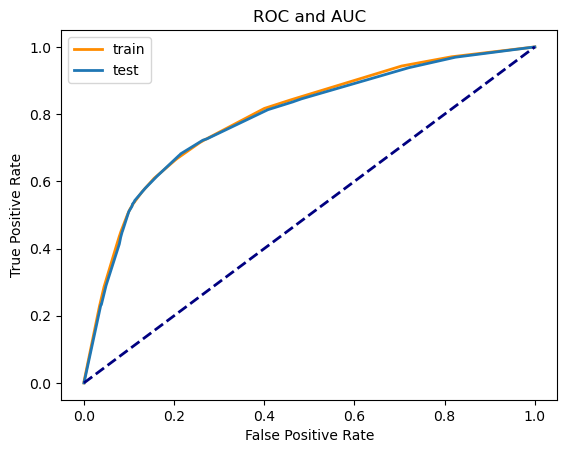

Test AUC score: 0.7883084053130532
Train AUC score: 0.7936555204894143


In [46]:
#Get the probability for each point in the test set.
y_proba_test_dec = best_dec_tree.predict_proba(X_test_S)[:,1]

#Get the probability for each point in the train set.
y_proba_train_dec = best_dec_tree.predict_proba(X_train_S)[:,1]

# Compute ROC curve and AUC for for the one class
roc_auc_test = roc_auc_score(y_test, y_proba_test_dec)
fprs_test, tprs_test, thresholds_test = roc_curve(y_test, y_proba_test_dec)

fprs_train, tprs_train, thresholds_train = roc_curve(y_train, y_proba_train_dec)
roc_auc_train = roc_auc_score(y_train, y_proba_train_dec)

# Plot the ROC curve.
plt.figure()
plt.plot(fprs_train, tprs_train, color='darkorange', lw=2, label='train')
plt.plot(fprs_test, tprs_test, lw=2, label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="best")
plt.show()
print(f"Test AUC score: {roc_auc_test}")
print(f"Train AUC score: {roc_auc_train}")

We can see that the ROC curve of test data is almost equal to the ROC curve of the training data, and they are close to the top-left corner. 

The test AUC score is 0.788 and the train AUC score is 0.793. It also indicates that the model generalizes well from training to test data without significant overfitting or underfitting. Decision Tree Classifier predicts better than Logistic Regression model.

##### 3.3. K-nearest neighbors model evaluation

Let's look at the K-nearest neighbors model confusion matrix: 

/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


<Figure size 800x600 with 0 Axes>

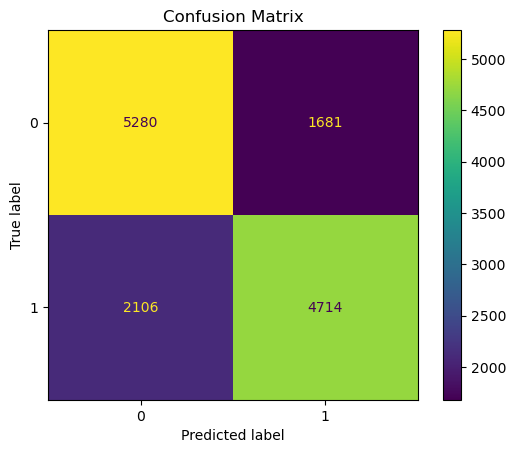

In [47]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(best_KNN, X_test_S, y_test, values_format='d')
plt.title('Confusion Matrix')
plt.show()

We can see that:
* 5280 patients that were correctly predicted to be without a CVD (true negative)
* 2106 patients that were incorrectly predicted to be without CVD (false negative), in reality they have this diagnose
* 1681 patients that were incorrectly predicted to be with a CVD (false positive), in reality they were healthy
* 4714 patients that were correctly predicted to be with a CVD(true positive)

Now let's look at the classification report: 

In [48]:
from sklearn.metrics import classification_report

#Get predictions
y_pred_knn = best_KNN.predict(X_test_S)

#make classification report
report_knn = classification_report(y_test, y_pred_knn)
print(report_knn)

              precision    recall  f1-score   support

           0       0.71      0.76      0.74      6961
           1       0.74      0.69      0.71      6820

    accuracy                           0.73     13781
   macro avg       0.73      0.72      0.72     13781
weighted avg       0.73      0.73      0.72     13781



/opt/anaconda3/envs/plotly_bokeh2/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


We observe that the *precision*, is 0.74 and the *recall*, is 0.69. The *F1-score*, is 0.71, and the *accuracy* is 0.73. K-nearest neighbors classifier has better recall and less precision, but the same accuracy and F1-score. 

Now, let's look at the ROC curse and AUC score: 

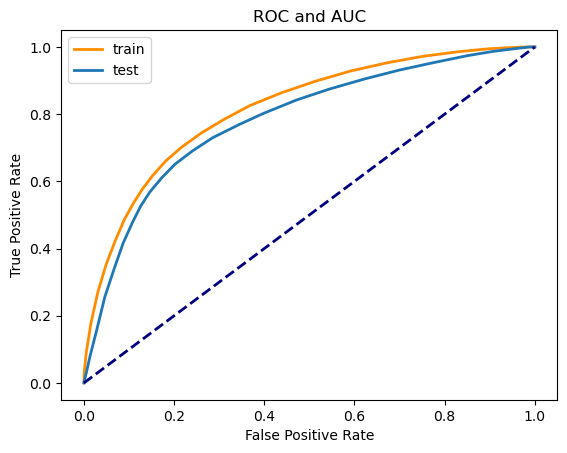

Test AUC score: 0.7822650262185508
Train AUC score: 0.8165096467056143


In [49]:
#Get the probability for each point in the test set.
y_proba_test_knn = best_KNN.predict_proba(X_test_S)[:,1]

#Get the probability for each point in the train set.
y_proba_train_knn = best_KNN.predict_proba(X_train_S)[:,1]

# Compute ROC curve and AUC for for the one class
roc_auc_test = roc_auc_score(y_test, y_proba_test_knn)
fprs_test, tprs_test, thresholds_test = roc_curve(y_test, y_proba_test_knn)

fprs_train, tprs_train, thresholds_train = roc_curve(y_train, y_proba_train_knn)
roc_auc_train = roc_auc_score(y_train, y_proba_train_knn)

# Plot the ROC curve.
plt.figure()
plt.plot(fprs_train, tprs_train, color='darkorange', lw=2, label='train')
plt.plot(fprs_test, tprs_test, lw=2, label='test')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="best")
plt.show()
print(f"Test AUC score: {roc_auc_test}")
print(f"Train AUC score: {roc_auc_train}")

We can observe that the ROC curve of training data is slightly above the ROC curve of the test data, and they are close to the top-left corner. 

The test AUC score is 0.782 and we have the best train AUC score so far- 0.817. It also indicates that the model generalizes well from training to test data without significant overfitting or underfitting. K-nearest neighbors classifier predicts better than other two models.

#### **<a id='Best_model'> 4. Best model, optimization </a>**

Let's look at the following table: 

|                 | **Logistic regression** | **Decision Tree** | **K nearest neighbors** |
|-----------------|-------------------------|-------------------|-------------------------|
| **Train score** | 0.727                   | 0.731             | 0.743                    |
| **Test score**  | 0.727                   | 0.733             | 0.725                    |
| **Accuracy**    | 0.73                    | 0.73              | 0.73                    |
| **Precision**   | 0.75                    | 0.76              | 0.74                    |
| **Recall**      | 0.68                    | 0.68              | 0.69                    |
| **F-1 score**   | 0.71                    | 0.73              | 0.72                    |
| **Test AUC**    | 0.785                   | 0.788             | 0.782                   |
| **Train AUC**   | 0.79                   | 0.793             | 0.817                   |

We observe that we have the **same Accuracy of 0.73**. Decision Tree Classifier, has better **Test score of 0.74**, better **Precision of 0.76**, better **F1-score of 0.73** and better **Test AUC score of 0.79**. 

But ***K-nearest neighbors*** has better **Train score of 0.74**, better **Recall of 0.69** and better **Train AUC score of 0.82**.

Now let's look at the comparison of confusion matrix of all models: 

| Confusion matrix   | **Logistic regression** | **Decision Tree** | **K nearest neighbors** |
|--------------------|-------------------------|-------------------|-------------------------|
| **True negative**  | 5408                    | 5474              | 5280                    |
| **False negative** | 2216                    | 2182              | 2106                    |
| **True positive**  | 4604                    | 4638              | 4714                    |
| **False positive** | 1553                    | 1487              | 1681                    |

As our main objective is to have *less False Negative* predictions and more *True Positive* predictions, we see that K-nearest neighbors classifier has the smalles number of False negative predictions (2106) and highest number of True positive predictions (4714). 

**In conclusion**, between these three models, the best one in my opinion is K-nearest neighbors. 

##### Optimize the KNN model

To make our model better, we can try to look at the different y thresholds and look at the precision and recall score. Our goal is to have a balance between precision and recall score.

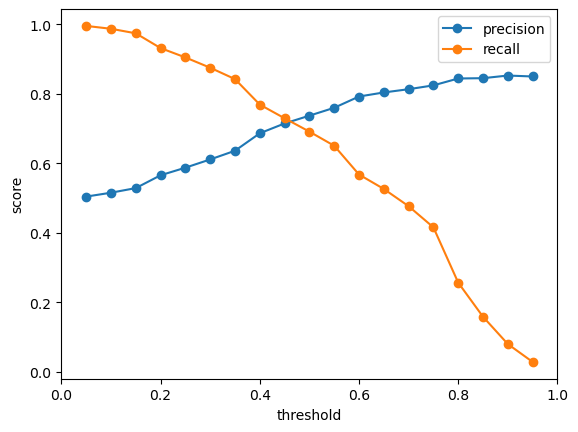

In [50]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Vary thresholds by 0.05 from 0.05 to 0.95
thresholds = np.arange(0.05, 1, 0.05)

precisions = list()
recalls = list()

for threshold in thresholds:

    # Apply threshold
    y_threshold = np.where(y_proba_test_knn > threshold, 1, 0)

    # Calculate precision and recall
    precision = precision_score(y_test, y_threshold)
    recall = recall_score(y_test, y_threshold)

    # Append to list
    precisions.append(precision)
    recalls.append(recall)

# Visualize the result
plt.figure()
plt.plot(thresholds, precisions, label='precision', marker='o')
plt.plot(thresholds, recalls, label='recall', marker='o')
plt.xlim(0, 1)
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.show()

Therefore, we can observe that around 0.40-0.47, the Recall and Precision score are more in balance. Let's look at the y_threshold of 0.43:

In [104]:
y_threshold_test = np.where(y_proba_test_knn > 0.43, 1, 0)
y_threshold_train = np.where(y_proba_train_knn > 0.43, 1, 0)

print("Threshold of 0.43:")
print(f"Precision score: {precision_score(y_test, y_threshold)}")
print(f"Recall score: {recall_score(y_test, y_threshold)}")
train_score = np.mean(y_threshold_train == y_train)
test_score = np.mean(y_threshold_test == y_test)
print(f'Train score: {train_score}')
print(f'Test score: {test_score}')

Threshold of 0.47:
Precision score: 0.7147371444987073
Recall score: 0.7296187683284457
Train score: 0.7362940386778419
Test score: 0.7118496480661781


Therefore, we can see that the Precision score 0.714 and Recall score 0.729 are almost similar. Also the train score is 0.736 and test score is 0.712. 

Let's look at the confusion matrix with the new threshold of 0.43: 

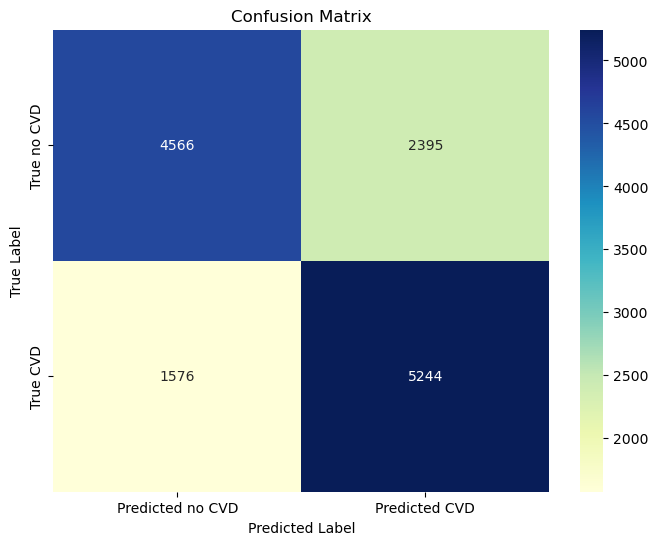

In [114]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for test set
cm = confusion_matrix(y_test, y_threshold_test)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=['Predicted no CVD', 'Predicted CVD'], 
            yticklabels=['True no CVD', 'True CVD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Therefore, we can observe that the number of False Negative predictions is lower (from 2106 to 1576). But also the number of False Positive has risen (from 1681 to 2395).

We can look more into it in the next Sprint, to optimize and find the best model that will predict with the highest accuracy and with the lowest number of False Negative predictions. 

#### **<a id='Future_steps'> 5. Future steps </a>**

For the next Sprint, we will: 
- try other more advanced models: random forest, gradient boosting machines, adaBoost, neural network, support vector machines, naive bayes, etc.
- evaluate the models and find best model and optimize it
- save the best model, look at the model's parameters
- do an user friendly web app using Streamlit Framework
- use new data from user to predict new values
- do reccomendations using the coeficients from the model and new dataset that contains reccomendations

#### **<a id='Conclusion'> Conclusion </a>**

In this Sprint we did the following:
1. Pre-processed our data and made it ready for modelling
2. Data setup, test and train split and scalling 
3. Make the baseline model: Logistic Regression
4. Find the best parameters for Logistic Regression and with them, make the model 
5. Find the best parameters for Decision Tree Classifier and with them, make the model 
6. Find the best parameters for K-Nearest Neighbors Classifier and with them, make the model
7. Models evaluation: confusion matrix, classification report, ROC curve and AUC score
8. Choose the best model and minimize the False Negative predictions 
